In [1]:

# This notebook needs pymc and arviz to be installed
# in the used environment. Either install them by the method
# of your choice or uncomment the code below and run it.
#import sys
#!{sys.executable} -m pip install arviz pymc

# Rescoring Using Bayesian and Frequentist Logistic Regression

## Introduction

After the initial scoring of Peptide Spectrum Matches (PSM) by sage, additional information
such as the deviation of the spectrum's ion mobility or retention time to those predicted for
the peptide can be utilized to refine the scoring. This process is called rescoring.
Here, a statistical model or machine learning approaches are trained to predict wether the peptide
behind a PSM is a target or a decoy. 



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
plt.style.use("bmh")
pd.set_option('display.max_columns', 100)

# The features we want to use for rescoring

features = [
    "score",
    "delta_rt",
    "delta_ims",
    "cosine_similarity",
    "delta_mass",
    "rank",
    "isotope_error",
    "average_ppm",
    "delta_next",
    "delta_best",
    "matched_peaks",
    "longest_b",
    "longest_y",
    "longest_y_pct",
    "missed_cleavages",
    "matched_intensity_pct",
    "poisson",
    "charge",
    "intensity_ms1",
    "intensity_ms2",
    "collision_energy",
    "spectral_entropy_similarity",
    "spectral_correlation_similarity_pearson",
    "spectral_correlation_similarity_spearman",

]

## Preparing the Data


As input data we will use a downsampled PSM dataset provided in "/data".
We will split the data roughly in half and use one half for training and the other to evaluate our rescoring models.

In [3]:
data_whole = pd.read_csv("./data/psm_data.csv", usecols=features+["decoy","match_idx"]).assign(decoy = lambda x: x.decoy.astype(int))
# shuffle data for train test split
data_shuffled = data_whole.sample(frac=1, random_state=42)


In [4]:
# train test split based on peptide sequence
# we want to make sure that PSMs of the same peptide
# do not occur in both train and test set 
match_idx_train = []
match_idx_test = []

size_data = data_shuffled.shape[0]
frac_train = 0
for mi in data_shuffled.match_idx.unique():
    if frac_train < 0.5:
        match_idx_train.append(mi)
        frac_train = data_shuffled.loc[data_shuffled.match_idx.isin(match_idx_train)].shape[0]/size_data
    else:
        match_idx_test.append(mi)
        
        
data_train = data_shuffled[data_shuffled.match_idx.isin(match_idx_train)]
data_test = data_shuffled[data_shuffled.match_idx.isin(match_idx_test)]

y_train = data_train["decoy"]
X_train = data_train.loc[:, features]

y_test = data_test["decoy"]
X_test = data_test.loc[:, features]


# Standardize the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

First we want to see the initial score distribution (in the test set) of PSMs that come from
target and decoy peptides, respectively. We use the negative hyperscore to make it more comparable to the
logit values of the logistic regression models.

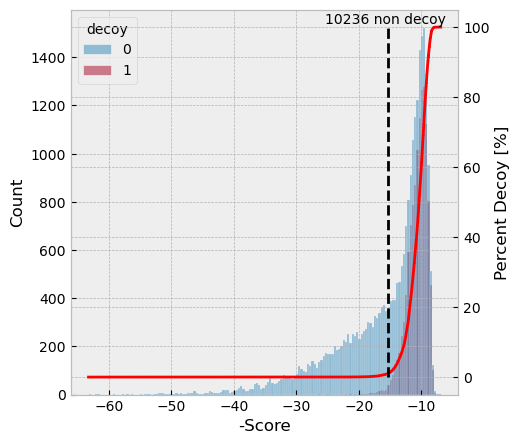

In [5]:
before_rescoring = (data_test.assign(score = lambda x: -x["score"])
                            .sort_values("score")
                            .assign(percent_decoy= lambda x: x["decoy"].cumsum() / x["decoy"].sum() * 100)
                            .assign(count_target = lambda x: (1-x["decoy"]).cumsum()))

Fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax2 = ax1.twinx()

ax2.plot(before_rescoring["score"], before_rescoring["percent_decoy"], color="red")
sns.histplot(before_rescoring, x="score", ax=ax1, hue="decoy")

ax2.set_ylabel("Percent Decoy [%]")
ax1.set_xlabel("-Score")
# get the last row where the percent decoy is below or equal to 1
cutoff = before_rescoring.where(before_rescoring["percent_decoy"] <= 1).dropna().tail(1)
ax2.vlines(cutoff["score"], 0, 100, color="black", linestyle="--")
ax2.annotate(f"{cutoff['count_target'].values[0]:.0f} non decoy", (cutoff["score"].values[0]-10, 101), color="black")
plt.show()

This plot shows that with the initial score at a FDR of 1% 10,236 PSM are selected.
Now one could train a variety of statistical or machine learning models to better separate true
hits with false positive hits. In this notebook, we will use a bayesian and a frequentist logistic regression
model as examples. 

## Define the Bayesian Model

For formulation of the bayesian model the python library [PyMC](https://www.pymc.io/welcome.html) is used.
The bayesian logistic regression can be described like this:

$$

$$

It can be shown, that the usage of a normal prior for the parameters
of the bayesian logistic regression corresponds to the L2-regularization in
the frequentist model.

In [6]:
with pm.Model(coords={"peptides": X_train.index.values,
                      "features": X_train.columns}) as logistic_model:
    x_data = pm.Data("x_data", X_train_scaled)
    y_data = pm.Data("y_data", y_train)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0 , sigma=0.1, shape=X_train_scaled.shape[1], dims=["features"])

    logit_p = pm.Deterministic("logit_p", alpha + pm.math.dot(x_data, beta), dims=["peptides"])
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=y_data, dims=["peptides"])
        

## Sample from the Posterior Distribution

Once the model is defined, we can sample from the posterior distribution and
use these samples to predict on new data by sampling from the posterior predictive distribution.

In [7]:
with logistic_model as model:
    idata = pm.sample(init="adapt_diag") # sample from the posterior
    pm.set_data({"x_data": X_test_scaled, "y_data": y_test}) # set the new (test) data
    model.set_dim("peptides", X_test_scaled.shape[0], X_test.index.values) # set the new dimensions and coords
    model.set_dim("features", X_test_scaled.shape[1], X_test.columns)
    pm.sample_posterior_predictive(idata, var_names=["obs","logit_p"], predictions=True, extend_inferencedata=True) # sample from the posterior predictive
    

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 187 seconds.
Sampling: [obs]


Output()

We can then display the posterior and its sampling trace via the `plot_trace` function
of the [arviz](https://python.arviz.org/en/stable/) library.

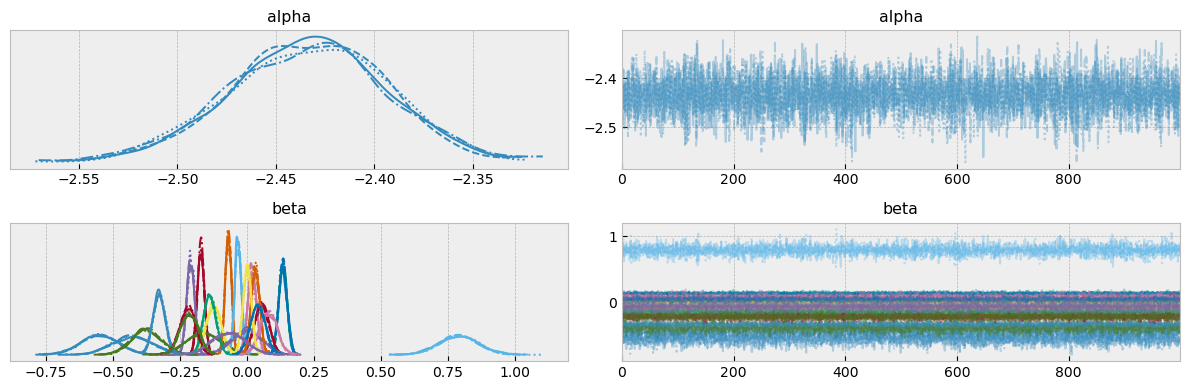

In [8]:
az.plot_trace(idata, var_names=["alpha", "beta"])
plt.tight_layout()
plt.show()

As this plot is quite crowded, we could summarize posterior information using the
mean and the bayesian central credible intervals (94%). We will focus on the
$\beta$ parameters, as these represent the feature importances.

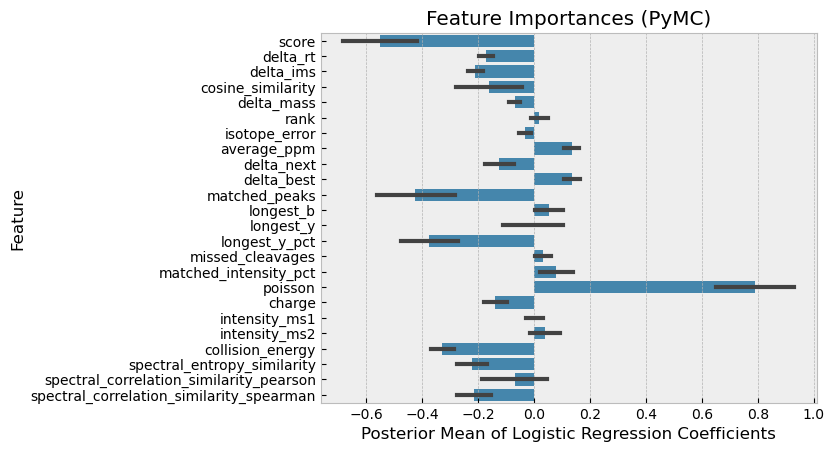

In [9]:
feature_importances_bayesian = idata.posterior.beta.to_dataframe().reset_index()
sns.barplot(data=feature_importances_bayesian, x="beta", y="features", errorbar=("pi",94))
plt.xlabel("Posterior Mean of Logistic Regression Coefficients")
plt.ylabel("Feature")
plt.title("Feature Importances (PyMC)")
plt.show()

Now let us have a look how many PSM will be selected after rescoring
using a FDR of 1%.

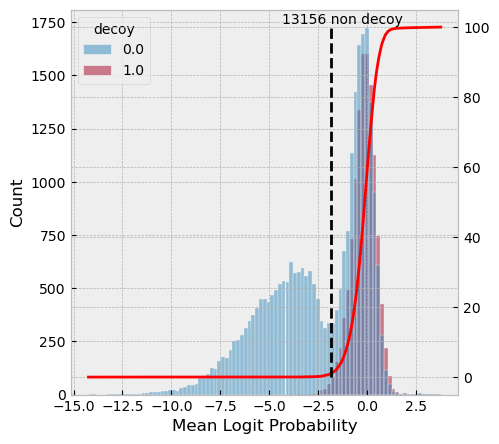

In [10]:
decoy_peptides = data_test.loc[data_test["decoy"]==1,:].index
target_peptides = data_test.loc[data_test["decoy"]==0,:].index
posterior_decoy = idata.predictions.logit_p.sel(peptides=decoy_peptides).mean(dim=["chain","draw"]).values.flatten()
posterior_target = idata.predictions.logit_p.sel(peptides=target_peptides).mean(dim=["chain","draw"]).values.flatten()

after_rescoring_pymc = (pd.DataFrame({"mean_logit_p":   np.concatenate([posterior_decoy, posterior_target]),
                                      "decoy":          np.concatenate([np.ones_like(posterior_decoy), np.zeros_like(posterior_target)])})
                            .sort_values("mean_logit_p")
                            .assign(percent_decoy= lambda x: x["decoy"].cumsum() / x["decoy"].sum() * 100)
                            .assign(count_target = lambda x: (1-x["decoy"]).cumsum()))
Fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax2 = ax1.twinx()

ax2.plot(after_rescoring_pymc["mean_logit_p"], after_rescoring_pymc["percent_decoy"], color="red")
sns.histplot(after_rescoring_pymc, x="mean_logit_p", ax=ax1, hue="decoy")

cutoff = after_rescoring_pymc.where(after_rescoring_pymc["percent_decoy"] <= 1).dropna().tail(1)
ax2.vlines(cutoff["mean_logit_p"].values[0], 0, 100, color="black", linestyle="--")
ax2.annotate(f"{cutoff['count_target'].values[0]:.0f} non decoy", (cutoff["mean_logit_p"].values[0]-2.5, 101), color="black")

ax1.set_xlabel("Mean Logit Probability")
sns.move_legend(ax1, "upper left")
plt.show()

The plot above illustrates how rescoring increases the number of PSMs that would be accepted, if a 1% FDR is applied. 
The plot also illustrates that the target distribution becomes bimodal, with a sharp peak around 0, that approximately matches
the decoy distribution and a broader peak to its left. Hence the plot also explains the principle behind rescoring:
It assumes that decoy PSMs have the same properties as PSMs coming from random hits in the target database and that a model 
trained to separate decoy hits from target hits also separates true hits from random hits. 

## Frequentist Model

For the frequentist logistic regression we will use the implementation of [scikit-learn](https://scikit-learn.org/stable/).
As mentioned above the frequentist analogue to the normal priors is a L2-regularization.

In [11]:
clf = LogisticRegression(penalty="l2", C=0.01)

clf.fit(X_train_scaled, y_train)
logit_p = clf.decision_function(X_test_scaled)

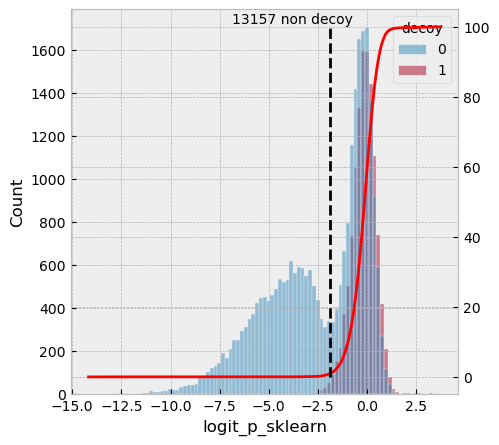

In [12]:
after_rescoring_sklearn = (data_test.assign(logit_p_sklearn = logit_p)
                            .sort_values("logit_p_sklearn")
                            .assign(percent_decoy= lambda x: x["decoy"].cumsum() / x["decoy"].sum() * 100)
                            .assign(count_target = lambda x: (1-x["decoy"]).cumsum()))

Fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax2 = ax1.twinx()

sns.histplot(after_rescoring_sklearn, x="logit_p_sklearn", ax=ax1, hue="decoy")
ax2.plot(after_rescoring_sklearn["logit_p_sklearn"], after_rescoring_sklearn["percent_decoy"], color="red")


cutoff = after_rescoring_sklearn.where(after_rescoring_sklearn["percent_decoy"] <= 1).dropna().tail(1)

ax2.vlines(cutoff["logit_p_sklearn"].values[0], 0, 100, color="black", linestyle="--")
ax2.annotate(f"{cutoff['count_target'].values[0]:.0f} non decoy", (cutoff["logit_p_sklearn"].values[0]-5, 101), color="black")
plt.show()

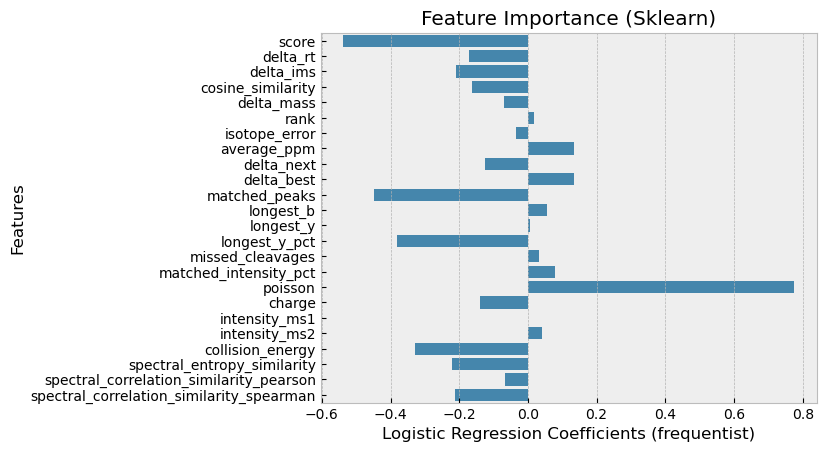

In [13]:
feature_importances_frequentist = pd.DataFrame({"features": X_test.columns, "beta": clf.coef_.flatten()})
sns.barplot(data = feature_importances_frequentist, x="beta", y="features")
plt.xlabel("Logistic Regression Coefficients (frequentist)")
plt.ylabel("Features")
plt.title("Feature Importance (Sklearn)")
plt.show()

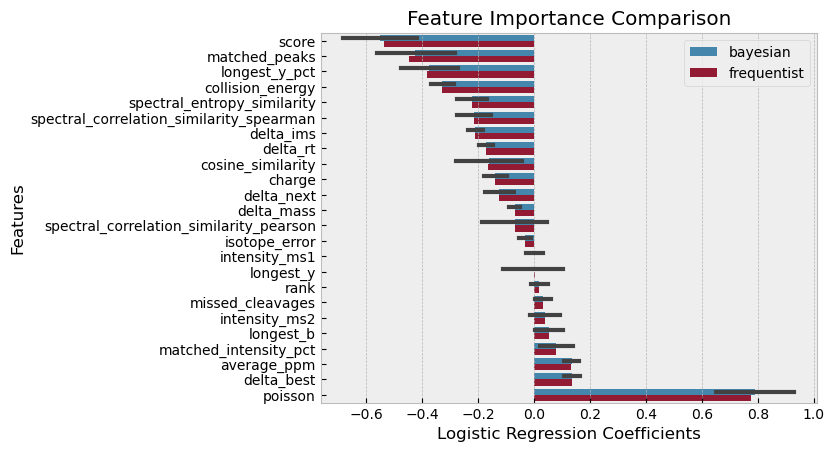

In [14]:
feature_importances_comparison = pd.concat([feature_importances_bayesian.loc[:,["features","beta"]].assign(method="bayesian"),feature_importances_frequentist.assign(method="frequentist")])
sns.barplot(data = feature_importances_comparison, x="beta", y="features", hue="method", errorbar=("pi",94), order=feature_importances_frequentist.sort_values("beta").features)
plt.xlabel("Logistic Regression Coefficients")
plt.ylabel("Features")
plt.title("Feature Importance Comparison")
plt.legend()
plt.show()

The two plots above demonstrate that the coefficients of the frequentist logistic model correspond to the posterior mean of the bayesian model.
However, the posterior samples of the bayesian approach provide additional information on the uncertainty of the model's inference.